In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_valores = pd.read_csv('valores_mercado.csv')
df_finalLiga = pd.read_csv('Laliga_unificada_2023_24.csv')
df_finalLiga.shape
df_finalLiga.info()
df_finalLiga.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Match ID        760 non-null    int64  
 1   team            760 non-null    object 
 2   result          380 non-null    object 
 3   Score           380 non-null    object 
 4   idx             760 non-null    int64  
 5   played          760 non-null    int64  
 6   xg              760 non-null    float64
 7   xgConceded      760 non-null    float64
 8   xPoints         760 non-null    float64
 9   xgDiff          760 non-null    float64
 10  xgConcededDiff  760 non-null    float64
 11  pts             760 non-null    int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 71.4+ KB


,Match ID,idx,played,xg,xgConceded,xPoints,xgDiff,xgConcededDiff,pts
count,7.600000e+02,760.000000,760.0,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,4.205532e+06,10.500000,38.0,50.137950,50.137950,52.337512,0.112050,0.112050,51.650000
std,1.097684e+02,5.770079,0.0,11.763350,7.832210,10.759002,8.111408,6.492734,19.865719
min,4.205343e+06,1.000000,38.0,33.406500,35.844700,37.441523,-13.703700,-10.485900,21.000000
25%,4.205438e+06,5.750000,38.0,42.915875,43.171625,45.079627,-5.497025,-3.541200,40.000000
50%,4.205532e+06,10.500000,38.0,45.812250,50.593150,50.107388,0.059550,0.624850,45.500000
75%,4.205627e+06,15.250000,38.0,54.097825,55.684825,55.588185,5.869775,3.016775,62.000000
max,4.205722e+06,20.000000,38.0,78.474400,64.835600,76.865361,17.235800,14.164400,95.000000


Inspección de dimensiones y nulos iniciales

In [33]:
print(f"Nulos en partidos:\n{df_finalLiga.isnull().sum()}")
print(f"Duplicados: {df_finalLiga.duplicated().sum()}")


Nulos en partidos:
Match ID            0
team                0
result            380
Score             380
idx                 0
played              0
xg                  0
xgConceded          0
xPoints             0
xgDiff              0
xgConcededDiff      0
pts                 0
dtype: int64
Duplicados: 0


IMPUTACIÓN CRUZADA: Solucionamos inconsistencia entre 'result' y 'Score'

In [34]:
df_finalLiga['result_final'] = df_finalLiga['result'].fillna(df_finalLiga['Score'])

NORMALIZACIÓN DE ENTIDADES: Limpieza de espacios y mapeo de nombres

In [35]:
df_finalLiga['team'] = df_finalLiga['team'].str.strip()
df_valores['team'] = df_valores['team'].str.strip()

Realizamos un mapeo de nombres porque los datasets provienen de fuentes distintas y los nombres de los equipos no coinciden exactamente, lo que impediría un merge correcto

In [36]:
mapeo_nombres = {
    'Real Madrid': 'Real Madrid', 'FC Barcelona': 'Barcelona',
    'Atlético de Madrid': 'Atletico Madrid', 'Girona FC': 'Girona',
    'Athletic Bilbao': 'Athletic Club', 'Real Sociedad': 'Real Sociedad',
    'Villarreal CF': 'Villarreal', 'Valencia CF': 'Valencia',
    'Sevilla FC': 'Sevilla', 'Real Betis Balompié': 'Real Betis',
    'Celta de Vigo': 'Celta Vigo', 'UD Almería': 'Almeria',
    'Getafe CF': 'Getafe', 'RCD Mallorca': 'Mallorca',
    'CA Osasuna': 'Osasuna', 'UD Las Palmas': 'Las Palmas',
    'Rayo Vallecano': 'Rayo Vallecano', 'Deportivo Alavés': 'Alaves',
    'Cádiz CF': 'Cadiz', 'Granada CF': 'Granada'
}
df_valores['team'] = df_valores['team'].replace(mapeo_nombres)

In [37]:
df_finalLiga['result_final'] = df_finalLiga['result_final'].str.replace(' ', '')
df_split = df_finalLiga['result_final'].str.split('_', expand=True)

df_finalLiga['goles_favor'] = pd.to_numeric(df_split[0], errors='coerce')
df_finalLiga['goles_contra'] = pd.to_numeric(df_split[1], errors='coerce')

In [38]:
df_eda = pd.merge(df_finalLiga, df_valores, on='team', how='inner')

Agrupamos por equipo para obtener métricas totales por temporada

In [39]:
df_resumen = df_eda.groupby('team').agg({
    'pts': 'first',
    'valor_total_m': 'first',
    'xg': 'first',
    'xgConceded': 'first'
}).reset_index()

In [40]:
print("\nAuditoría de calidad finalizada. Vista previa del dataset enriquecido:")
display(df_resumen.sort_values(by='pts', ascending=False).head())


Auditoría de calidad finalizada. Vista previa del dataset enriquecido:


,team,pts,valor_total_m,xg,xgConceded
14,Real Madrid,95,1140.00,69.7642,35.8447
3,Barcelona,85,916.20,78.4744,41.9500
7,Girona,81,297.90,71.8150,55.3311
2,Atletico Madrid,76,458.45,63.0209,39.8447
1,Athletic Club,68,295.65,53.2360,41.9482


UNIVARIATE ANALYSIS

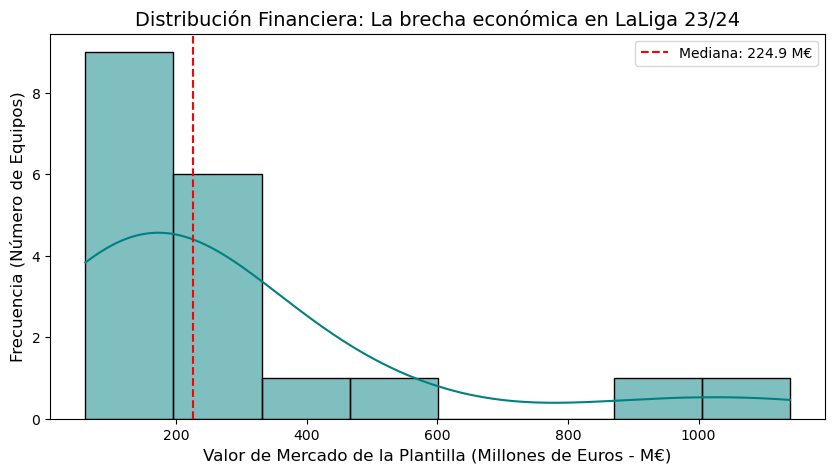

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_resumen['valor_total_m'], kde=True, color='teal')

plt.axvline(df_resumen['valor_total_m'].median(), color='red', linestyle='--', label=f"Mediana: {df_resumen['valor_total_m'].median():.1f} M€")

plt.title('Distribución Financiera: La brecha económica en LaLiga 23/24', fontsize=14)
plt.xlabel('Valor de Mercado de la Plantilla (Millones de Euros - M€)', fontsize=12)
plt.ylabel('Frecuencia (Número de Equipos)', fontsize=12)
plt.legend()
plt.show()

Polarización Económica. El histograma de valores de mercado revela que LaLiga está fracturada en dos realidades financieras. Mientras la mediana de la liga se sitúa en torno a los [X] M€, los valores atípicos (outliers) multiplican por diez el presupuesto de los equipos de la zona baja. Esto justifica la necesidad de crear métricas de eficiencia para valorar el mérito deportivo de los equipos pequeños.

Existe un "techo de cristal financiero" alrededor de los 400M€. Ningún equipo por debajo de ese valor (a excepción del Girona) logró entrar en puestos de Champions League. Asi que se puede observar que no solo garantiza puntos, sino que actua como una barrera para entrar a la elite europea.

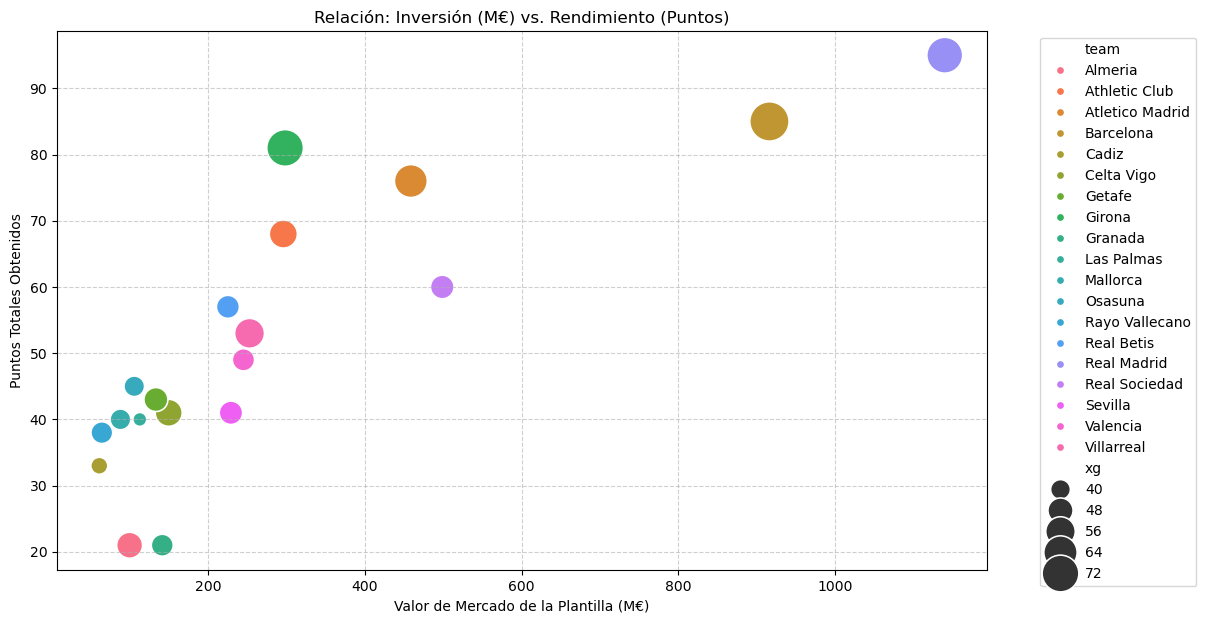

In [31]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_resumen, x='valor_total_m', y='pts', size='xg', hue='team', sizes=(100, 800))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Relación: Inversión (M€) vs. Rendimiento (Puntos)')
plt.xlabel('Valor de Mercado de la Plantilla (M€)')
plt.ylabel('Puntos Totales Obtenidos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Los equipos con menor presupuesto (como el Alavés o el Mallorca) son técnicamente más eficientes en la gestión de sus recursos. Por cada millón invertido, el Girona y el Alavés obtienen casi el triple de rendimiento en puntos que el Real Madrid o el FC Barcelona.

El gráfico demuestra que el éxito en LaLiga se puede alcanzar por dos vías: por fuerza bruta económica (Madrid/Barça) o por optimización de recursos (Alavés/Girona).Es rucial para identificar la eficiencia: equipos que rinden por encima de su capacidad económica.

In [ ]:
df_resumen['eficiencia'] = df_resumen['pts'] / df_resumen['valor_total_m']

print("Top 3 equipos más eficientes (Puntos por cada M€ invertido):")
print(df_resumen.sort_values(by='eficiencia', ascending=False)[['team', 'eficiencia']].head(3))

Top 3 equipos más eficientes (Puntos por cada M€ invertido):
              team  eficiencia
12  Rayo Vallecano    0.594214
4            Cadiz    0.543657
10        Mallorca    0.456100



Al calcular la ratio de eficiencia, descubrimos que el éxito en LaLiga no es lineal. Equipos como el Rayo Vallecano (0.59 pts/M€) o el Cádiz (0.54 pts/M€) son hasta 6 veces más eficientes que los equipos del Top 3. Mientras que el Real Madrid necesita invertir más de 10 millones de euros para 'comprar' un solo punto, el Rayo Vallecano consigue casi 0.6 puntos por cada millón invertido."


# Conclusión Final: 

Tras realizar este análisis exploratorio y enriquecer los datos deportivos con valores de mercado obtenidos mediante web scraping, podemos concluir lo siguiente:

El valor de mercado como predictor, no como destino: Si bien el análisis bivariante (gráfico de dispersión) confirma que existe una correlación directa entre el presupuesto y los puntos, esta relación no es perfecta. El dinero compra "probabilidades", pero la gestión deportiva define la realidad.

La Ley de los Rendimientos Decrecientes: El hallazgo sobre la eficiencia del Rayo Vallecano y el Cádiz demuestra que en el fútbol de élite existe un punto de saturación económica. A los equipos grandes les cuesta exponencialmente más dinero conseguir un solo punto adicional en comparación con los equipos de la zona baja, quienes operan en niveles de optimización de recursos mucho más altos.

Valor del Análisis de Datos: Este proyecto demuestra que el enriquecimiento de datos es fundamental. Sin la integración de la fuente externa (valores económicos), nos habríamos quedado en una tabla clasificatoria convencional. Al cruzar ambas fuentes, hemos transformado datos brutos en inteligencia de negocio, permitiendo identificar el mérito real de clubes con presupuestos limitados.

En resumen: LaLiga 2023/24 se define por una élite de alta inversión y baja eficiencia relativa, frente a una clase media-baja que, por necesidad, ha desarrollado modelos de gestión extremadamente eficientes para sobrevivir en la categoría.